# [Computational Social Science] Project 4: Unsupervised Learning

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ770    OHQ845   PAAQUEX  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ...  0.383802 -0.646584 -0.484200   
73576 -0.057306  0.128246  0.080373  ...  0.383802 -1.539259 -0.484200   
73579 -0.057306  0.128246 -0.189513  ...  0.383802 -1.539259  2.065262   
73581 -0.057306  0.128246  0.080373  ...  0.383802 -0.646584 -0.484200   
73584 -0.057306  0.128246  0.080373  ... -2.605509  0.246091  2.065262   

         SMQ860  SMQ870    SMQ872    SMQ874    SMQ878  SMAQUEX.x  HSD010  
SEQN                                                                      
73568  1.125008     0.0 -2.081666  1.087115  1.463404   0.612440       1  
73576  1.125008     0.0 -2.081666  1.087115 -0.683338  -1.632812       1  
73579 -0.888883     0.0  0.480384 -0.919866 -0.683338  -1.632812       2  
73581  1.125008     0.0  0.480384 -0.919866 -0.683338   0.612440       2  
73584  1.125008     0.0  0.480384 -0.919866  1.463404  -1.632812       3  

[5 rows x 242 columns]

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

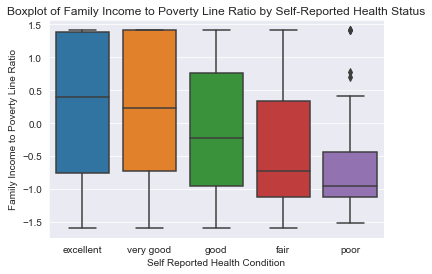

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

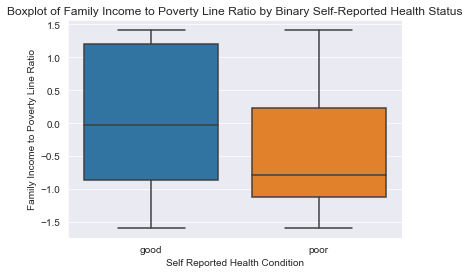

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

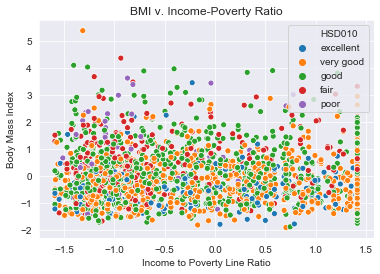

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

We chose 0.90 as a parameter to the PCA model, indicating that PCA will retain 90% of the variance and the minimum number of principal components needed to capture 90% variance will be used. In this case, 90% of the variance amounts to 120 principal components. Although there isn't a "perfect" formula to calculate the ideal variance principal components should explain, we chose 90% in alignment with the field which suggests 90-95% as one standard practice.

In [8]:
# Check out first 5 rows
nhanes_scaled.head()

DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   

       DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845  \
SEQN                                 ...                                 
73568 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -0.646584   
73576 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -1.539259   
73579 -0.057306  0.128246 -0.189513  ... -0.680203  0.383802 -1.539259   
73581 -0.057306  0.128246  0.080373  ... -0.680203  0.383802 -0.646584   
73584 -0.057306  0.128246  0.080373  ... -0.680203 -2.605509  0.246091   

        PAAQUEX    SMQ860  SMQ870    SMQ872    SMQ874    SMQ878  SMAQUEX.x  
SEQN                                                                        
73568 -0.484200  1.125008     0.0 -2.081666  1.087115  1.463404   0.612440  
73576 -0.484200  1.125008     0.0 -2.081666  1.087115 -0.683338  -1.632812  
73579  2.065262 -0.888883     0.0  0.480384 -0.919866 -0.683338  -1.632812  
73581 -0.484200  1.125008     0.0  0.480384 -0.919866 -0.683338   0.612440  
73584  2.065262  1.125008     0.0  0.480384 -0.919866  1.463404  -1.632812  

[5 rows x 241 columns]

In [9]:
from sklearn.decomposition import PCA
pca = PCA(0.90)
principalcomponents_nhanes = pca.fit_transform(nhanes_scaled)
pca.n_components_

120

In [10]:
#PCA on 120 components of NHANES dataset to have 90% of variance explained
from sklearn.decomposition import PCA
pca = PCA(n_components=120)
principalcomponents_nhanes = pca.fit_transform(nhanes_scaled)

In [11]:
#Explained variation per component
print(pca.explained_variance_ratio_)

[0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655592 0.01557116 0.01532197 0.01319964 0.01212789
 0.01157937 0.01155981 0.01110006 0.01004583 0.00943223 0.00932322
 0.00880415 0.0086902  0.00840106 0.0082603  0.00796172 0.00782773
 0.00753776 0.00723651 0.00711072 0.00694047 0.00679363 0.00645715
 0.0063964  0.00631739 0.00621784 0.00617767 0.00592796 0.00577447
 0.00568518 0.00562999 0.0056166  0.00555543 0.00549322 0.00543039
 0.00531549 0.00527964 0.00521747 0.00516056 0.00510901 0.00501947
 0.00498465 0.00495407 0.0049108  0.00484232 0.0048211  0.00474991
 0.00471976 0.00463769 0.00462329 0.00458683 0.00451141 0.00448754
 0.00446999 0.00438668 0.00437532 0.00433324 0.00429073 0.00425696
 0.00423472 0.0042031  0.00414637 0.0041181  0.00407644 0.00405787
 0.00403509 0.00397759 0.00393351 0.00393027 0.00389857 0.00383502
 0.00379378 0.0037717  0.00372996 0.00371246 0.00367686 0.00365636
 0.00361079 0.00359273 0.00351354 0.00347613 0.00346309 0.00342

In [12]:
#Cumulative variance explained 
np.cumsum(pca.explained_variance_ratio_)

array([0.10201961, 0.17824972, 0.22196164, 0.25078336, 0.27435468,
       0.29337098, 0.3114795 , 0.32803542, 0.34360658, 0.35892855,
       0.37212819, 0.38425608, 0.39583545, 0.40739525, 0.41849531,
       0.42854114, 0.43797337, 0.44729659, 0.45610074, 0.46479094,
       0.473192  , 0.4814523 , 0.48941402, 0.49724175, 0.50477951,
       0.51201602, 0.51912674, 0.52606721, 0.53286084, 0.53931799,
       0.5457144 , 0.55203179, 0.55824963, 0.5644273 , 0.57035526,
       0.57612972, 0.58181491, 0.5874449 , 0.5930615 , 0.59861694,
       0.60411016, 0.60954055, 0.61485604, 0.62013568, 0.62535315,
       0.6305137 , 0.63562271, 0.64064218, 0.64562683, 0.65058091,
       0.6554917 , 0.66033403, 0.66515512, 0.66990504, 0.6746248 ,
       0.67926249, 0.68388578, 0.6884726 , 0.69298402, 0.69747156,
       0.70194155, 0.70632823, 0.71070355, 0.71503679, 0.71932753,
       0.72358449, 0.72781921, 0.73202231, 0.73616868, 0.74028678,
       0.74436322, 0.74842109, 0.75245618, 0.75643376, 0.76036

### Barplot of Components

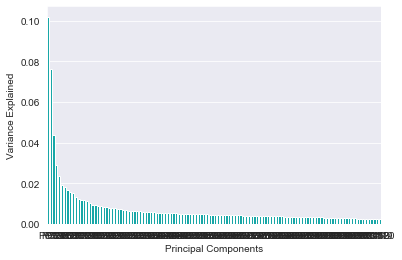

In [13]:
pca_df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                      'PC': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9', 
                             'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15','PC16', 'PC17',
                            'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 
                            'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33',
                            'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39','PC40', 'PC41', 
                             'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47','PC48', 'PC49',
                            'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57', 
                            'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65',
                            'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC72', 'PC73', 
                            'PC74', 'PC75', 'PC76', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81',
                            'PC82', 'PC83', 'PC84', 'PC85', 'PC86', 'PC87', 'PC88', 'PC89',
                            'PC90', 'PC91', 'PC92', 'PC93', 'PC94', 'PC95', 'PC96', 'PC97', 
                            'PC98', 'PC99', 'PC100', 'PC101', 'PC102', 'PC103', 'PC104', 'PC105',
                            'PC106', 'PC107', 'PC108', 'PC109', 'PC110', 'PC111', 'PC112', 'PC113', 
                             'PC114', 'PC115', 'PC116', 'PC117', 'PC118','PC119', 'PC120']})
sns.barplot(x='PC', y='var',
           data=pca_df, color="c")
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained');

### How many components will you use to fit a supervised learning model?

After exploring the data, particularly the explained variance per components and the cumulative variance explained, we've decided to only use 16 components to fit a supervised learning model. The first 16 components explain nearly 43% of variability. After component 16, the variance explained by each subsequent component is less than 1%. Therefore, it makes most sense to include the first 16 components to fit the learning model. 

### 2D Scatterplot of the first two components

In [15]:
pc_df = pd.DataFrame(data = principalcomponents_nhanes)
pc_df

plot_df = pd.concat([pc_df, hsd010], axis = 1)

#Recode to make hsd010 binary
plot_df['HSD010_binary'] = hsd010_binary = plot_df['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
plot_df

0         1         2         3         4         5         6  \
0     9.527811 -0.816224 -1.867092 -2.109904 -3.929392 -0.185322 -3.845008   
1    -5.838339 -3.692573  3.805750 -1.029714  0.394587  1.593165  2.711015   
2    -0.719454 -2.573200  0.907902 -4.755837 -1.798850  0.863669 -1.024265   
3     3.533627 -2.576983 -3.249123 -0.405467  3.999019  1.444425 -1.182104   
4    -6.872094 -4.194241  0.886831 -0.848979 -0.524862  0.073055  0.843819   
...        ...       ...       ...       ...       ...       ...       ...   
2059  2.643319 -1.689356 -0.702594 -0.538264 -1.021644 -0.677041  0.473136   
2060  1.037906 -0.118065  5.556447  1.630077  0.967743  1.146624  1.949585   
2061  1.130253 -0.970432  3.415387  1.206777 -3.631833  1.118370  1.361733   
2062  7.145092 -0.376753  1.753505 -0.939056 -4.665499  3.844265 -1.355272   
2063  0.050869 -0.967297 -4.447671 -0.503263  4.470236  4.852770 -2.765241   

             7         8         9  ...       112       113       114  \
0    -2.934907  1.514192  0.682710  ... -0.508868 -1.656465 -0.061599   
1    -0.740537  0.384199 -2.405975  ... -0.975645  1.616000 -0.122667   
2     0.632999  0.542108  0.449373  ... -0.133850 -0.002053  0.196784   
3     0.326660 -4.151148 -1.245296  ...  0.200718  1.171887 -0.049710   
4     0.987702  0.557231 -0.045088  ... -0.271024  0.287922  0.487166   
...        ...       ...       ...  ...       ...       ...       ...   
2059 -0.288996  0.959167 -1.238274  ...  0.237526 -0.857682 -1.235884   
2060  0.929127 -1.286789 -2.011601  ...  0.449134  0.683506  0.071085   
2061  1.827746 -2.339055  0.232350  ...  0.585130  0.356877 -0.168189   
2062  2.587607 -0.290033  0.612683  ... -0.289213  0.605023 -0.797033   
2063  3.354441 -1.704754 -1.960789  ...  0.900883 -0.269107 -0.892602   

           115       116       117       118       119  HSD010  HSD010_binary  
0    -0.631919 -0.045985  0.450118  0.841411  0.044607       1           good  
1    -1.198856  0.549672 -1.508354  1.040011 -0.462103       1           good  
2    -0.406066 -0.527959 -0.379611  0.282386  0.528596       2           good  
3    -0.853843  0.242687 -1.511036  0.016704  0.270033       2           good  
4    -0.679237 -0.055682 -0.128661  0.275865 -0.157957       3           good  
...        ...       ...       ...       ...       ...     ...            ...  
2059 -0.295727  0.198620  0.947733 -0.201223 -0.210739       3           good  
2060  0.170554 -0.352884  0.128680 -0.664654  0.387039       2           good  
2061  0.661794  0.160339 -0.470375  0.401858 -0.404210       4           poor  
2062 -0.977080 -1.039119  0.781314  0.461111  0.670603       1           good  
2063 -0.379312  0.316821 -0.183745 -0.589106  1.045981       2           good  

[2064 rows x 122 columns]

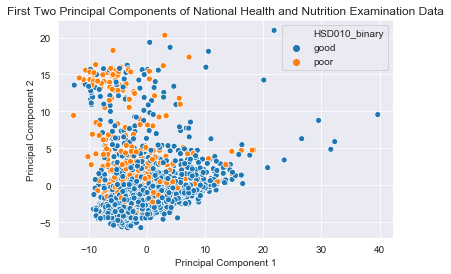

In [20]:
ax = sns.scatterplot(x = plot_df[0], y = plot_df[1], hue = 'HSD010_binary', data = plot_df)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components of National Health and Nutrition Examination Data")
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

## Your Answer Here

### Cluster nhanes

In [ ]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = ... # either hsd010 or hsd010_binary
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import keras
num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
model = Sequential()

model.add(
    Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...)
)

model.add(
    Dense(..., kernel_initializer= ..., activation= ...)
)

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Your Answer Here